In [104]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
np.set_printoptions(threshold=np.nan)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
from proj1_helpers import load_csv_data, predict_labels, create_csv_submission
from implementations import ls_gd_hyperparam, ls_sgd_hyperparam, ridge_gd_hyperparam,ridge_sgd_lambda
from preprocessing import standardize_train, add_bias, build_poly
from other import remove_999, remove_999col, replace_999, accuracy,replace_1, cross_validation
from plots import plot_train_valid, plot_train_valid_ridge
import math

## Load data
The output data -1 is transformed into 0.

The data must be sorted in 4 categories, depending on their -999 columns x_tr_1,x_tr_2...

For each of the four categories, the columns with -999 are taken out.

Then features are added as powers of features or combination of them

In [106]:
output_tr, input_tr, ids_train = load_csv_data('train.csv', sub_sample=False)

In [ ]:
def split_categories(input_tr):
    jet_num = 22
    cat_0 = input_tr[input_tr[:, jet_num] == 0]
    cat_1 = input_tr[input_tr[:, jet_num] == 1]
    cat_2 = input_tr[input_tr[:, jet_num] == 2]
    cat_3 = input_tr[input_tr[:, jet_num] == 3]
    return cat_0, cat_1, cat_2, cat_3

In [107]:
y_trainLR=replace_1(output_tr)

## Pre-processing

In [108]:
#input_train,y_train,input_valid,y_valid = cross_validation(input_tr,y_trainLR,1,10)
input_train =input_tr
y_train     =y_trainLR

#### No 999 line
We delete all the lines containing a -999 inside. The y lines corresponding are also deleted. The valid data are not changed.

We also try to have or not a bias.

In [115]:
# Careful to standardize the x_valid with the mean and std of x_train
x_train_no_999lin, y_train_no_999lin = remove_999(input_train, y_train)

x_train_no_999lin, mean, std      = standardize_train(x_train_no_999lin)
x_train_no_999linb                = add_bias(x_train_no_999lin)  # data biased

#### No 999 column
We delete all the columns (features) containing a -999 inside. The y data are not changed. The x_valid features corresponding are also changed.

All the data are unbiaised.

In [110]:
x_train_no_999col,_               = remove_999col(input_train,input_train)
x_train_no_999col, mean, std      = standardize_train(x_train_no_999col)
x_train_no_999colb                = add_bias(x_train_no_999col)

#### All features
We don't modify the data.

In [111]:
x_train, mean, std                = standardize_train(input_train)
x_trainb                          = add_bias(x_train)

#### Put 999 to 0
We replace all the 999 with a 0 inside the train data.
We also relace them in the valid data.

In [112]:
x_train_0_999                     = replace_999(input_train)
x_train_0_999, mean, std          = standardize_train(x_train_0_999)
x_train_0_999b                    = add_bias(x_train_0_999)

## Constant definitions

In [185]:
# Define the parameters of the algorithm. (probably change afterwards)
max_iters     = 1000                                 
batch_size    = 1
num_intervals = 20
nb_fold       = 10
nb_crossvalid = 1
lambdas       = np.linspace(0.005, 0.01, num_intervals)
lambda_       = 0.5

# Decide which features are used 
trx = x_train_no_999linb
try_= y_train_no_999lin

# Initialization
w_initial     = np.random.rand(trx.shape[1])

### GD least squares

In [166]:
gammas        = np.linspace(0.025, 0.2, num_intervals)
loss_valid_gd, loss_train_gd,w = ls_gd_hyperparam(gammas, nb_fold,nb_crossvalid,max_iters, trx, try_,w_initial)

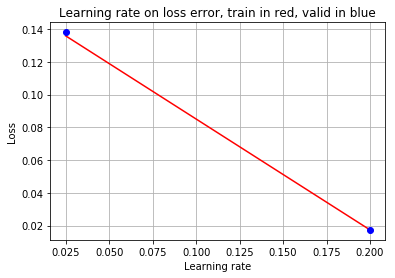

In [167]:
plot_train_valid(loss_train_gd, loss_valid_gd, gammas)

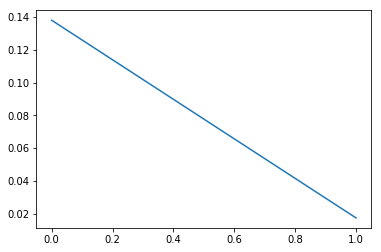

In [168]:
plt.plot(loss_valid_gd)

In [169]:
# Minimum values for ls_gd
idx = np.argmin(loss_valid_gd)
learning_rate_gd = gammas[idx]
ls_gd_loss = loss_valid_gd[idx]
print("The best learning_rate is",learning_rate_gd,"with a loss on validation set of",ls_gd_loss)

The best learning_rate is 0.2 with a loss on validation set of 0.01739506649584627


### SGD Least squares

In [ ]:
gammas        = np.linspace(0.0002, 0.0003, num_intervals)
loss_valid_sgd, loss_train_sgd,w = ls_sgd_hyperparam(gammas, nb_fold,nb_crossvalid,max_iters, trx, try_,w_initial)

In [ ]:
plot_train_valid(loss_train_sgd, loss_valid_sgd, gammas)
plt.plot(loss_valid_sgd)

In [201]:
# Minimum values for ls_sgd
idx = np.argmin(loss_valid_sgd)
learning_rate_sgd = gammas[idx]
ls_sgd_loss = loss_valid_sgd[idx]
print("The best learning_rate is",learning_rate_sgd,"with a loss on validation set of",ls_sgd_loss)

The best learning_rate is 0.0018 with a loss on validation set of 0.1362003616900732


### SGD Ridge regression

In [196]:
valid_r_sgd, train_r_sgd,w = ridge_sgd_lambda(lambdas, gammas, nb_fold,max_iters, trx, try_,w_initial)

0


ValueError: operands could not be broadcast together with shapes (20,) (31,) 

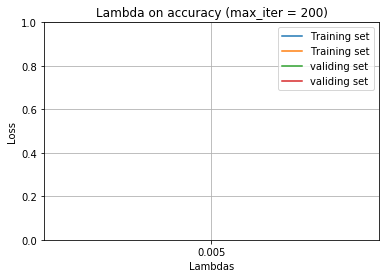

In [48]:
plot_train_valid_ridge(train_r_sgd, valid_r_sgd, lambdas)

In [49]:
# Minimum values for ls_sgd
ind = np.unravel_index(np.argmin(valid_r_sgd, axis=None), valid_r_sgd.shape)
lambd = lambdas[ind]
ls_sgd_loss = valid_r_sgd[ind]
print(lambd)
print(ls_sgd_loss)

IndexError: too many indices for array

### GD Ridge regression

In [51]:
loss_valid_r_gd, loss_train_r_gd,w = ridge_gd_hyperparam(lambdas, gammas, nb_fold,max_iters, trx, try_,w_initial)

In [52]:
train_gd_mean = np.mean(loss_train_r_gd, axis=2)
valid_gd_mean = np.mean(loss_valid_r_gd, axis=2)

In [53]:
# Minimum values for ls_sgd
ind = np.unravel_index(np.argmin(valid_gd_mean, axis=None), valid_gd_mean.shape)
learning_rate = gammas[ind[0]]
ls_gd_loss = valid_gd_mean[ind]
print(learning_rate)
print(ls_gd_loss)

0.005
13.224072660028202


## Logistic regression
Debugged but not sure from here: Il y aura probablement une correction du labo 5 pour améliorer / vérifier les fonctions de logistic regression

In [186]:
w_lr_init= np.random.rand(x_trainb.shape[1])

In [187]:
w_lr, loss_lr = logistic_regression(y_train,x_trainb, w_lr_init,1000,0.1)

In [195]:
loss_lr_train= compute_logreg_loss(y_train,x_trainb,w_lr)
acc_lr_train=accuracy(y_train,x_trainb,w_lr)

In [196]:
loss_lr_valid = compute_logreg_loss(y_valid,x_valb,w_lr)
acc_lr_valid=accuracy(y_valid,x_valb,w_lr)

In [197]:
print(loss_lr_train,acc_lr_train, loss_lr_valid, acc_lr_valid)

0.8871013457508762 0.6493288888888888 0.8960798587603032 0.65164


In [227]:
def log_reg_hyperparam(gammas, x_train, y_train, x_valid, y_valid, max_iters):
    loss_valid = np.zeros([len(gammas),1])
    loss_train = np.zeros([len(gammas),1])
    loss_valid = np.zeros([len(gammas),1])
    
    w_initial= np.random.rand(x_train.shape[1])
    
    for i, gamma in enumerate(gammas):  
        w, loss_tr = logistic_regression(y_train, x_train, w_initial, max_iters, gamma)
        loss_train[i] = loss_tr
        loss_valid[i] = compute_logreg_loss(y_valid, x_valid, w)
            
    return loss_valid, loss_train,w

In [231]:
num_intervals_log_reg = 100
gammas_log_reg     = np.linspace(0.005, 0.2, num_intervals_log_reg)
nb_fold_log_reg    = 10
nb_cross_valid_log_reg = 1
max_iters_log_reg  = 100

In [232]:
loss_valid,loss_train,_ = log_reg_hyperparam(gammas_log_reg,x_train,y_train,x_valid,y_valid,max_iters_log_reg)

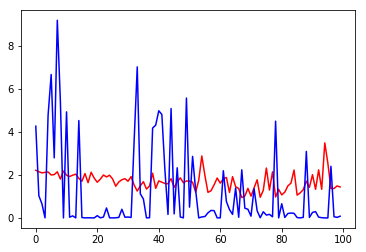

In [230]:
plt.plot(loss_valid, 'r-',loss_train,'b-')

## Regularized Logistic Regression

# Prediction de chaque méthode pour Kaggle

In [ ]:
y_pred = predict_labels(w, x_valid)